# Minimize experiments

## Minimize the Rosenbrock function

$$ f(x) = \sum_{d=1:D-1} 100 (x_{d+1} - x_d^a)^2 + (1-x_d)^2 $$

In [1]:
from minimize import line_search, kalman_filter_smoother
from helpers import plot_linesearch
import matplotlib.pyplot as plt

import os
from datetime import datetime

In [2]:
import autograd.numpy as np
from autograd import grad


def convert_to_1d_objective(f, x, d):
    """
    Converts a multivariate objective function f to the univariate function
    
        g(a) = f(x + a * d),
        
    handling the derivatives as well.
    """
    
    def g(a):
        
        ga, dfa = f(x + a * d)
        
        dga = np.dot(dfa, d)
        
        return np.array([[ga, dga]])
    
    return g
    

def rosenbrock(x, a):
    
    def f(x, a):
        return np.sum(100 * (x[1:] - x[:-1] ** a) ** 2 + (1 - x[:-1]) ** 2)
    
    df = grad(f, argnum=0)
    
    fx = f(x, a)
    dfx = df(x, a)
    
    return fx, dfx

In [3]:
x = np.ones(shape=(2,))

print(rosenbrock(x, 2))

standard_rosenbrock = lambda x : rosenbrock(x, a=2)

linesearch_objective = convert_to_1d_objective(standard_rosenbrock, x, d=x)

print(linesearch_objective(x))

(0.0, array([0., 0.]))
[[ 401. 1202.]]


In [4]:
def conjugate_gradients(objective, x0, c1, c2, wp_thresh, save_path):
    
    t0 = 0.
    t_guess = np.array([1.])
    num_dim = x0.shape[0]
            
    f, df = objective(x0)
    
    d = - df
    g = df
    diff = None
    
    x = x0
    xhist = [x]
    fhist = [f]
    
    names = ['t', 'y', 'wp_probs', 'mf', 'Vf', 'ms', 'Vs', 'iVC', 'post_probs']
    os.mkdir(f'{os.getcwd()}/{save_path}')
    
    print(save_path)
    
    for i in range(10):
        
        linesearch_objective = convert_to_1d_objective(objective, x, d)
        
        # Create y0 array
        y0 = np.array([[f, np.dot(df, d)]])
        
        if not (diff is None): t_guess = np.abs(diff / y0[0, 1])
            
        print(t_guess)
        
        t, y, wp_probs, mf, Vf, ms, Vs, iVC, post_probs = line_search(objective=linesearch_objective,
                                                                      c1=c1,
                                                                      c2=c2,
                                                                      wp_thresh=wp_thresh,
                                                                      t0=t0,
                                                                      y0=y0,
                                                                      t_guess=t_guess)
            
        os.mkdir(f'{os.getcwd()}/{save_path}/{str(i).zfill(5)}')
        
        for name, array in zip(names, [t, y, wp_probs, mf, Vf, ms, Vs, iVC, post_probs]):
            np.save(f'{os.getcwd()}/{save_path}/{str(i).zfill(5)}/{name}.npy', array)
            
        plot_linesearch(c1=c1,
                        c2=c2,
                        t_data=t,
                        mf=mf,
                        Vf=Vf,
                        ms=ms,
                        Vs=Vs,
                        iVC=iVC,
                        post_probs=post_probs,
                        wp_probs=wp_probs,
                        x=None,
                        y=y)
        
        idx_best = np.argmax(wp_probs)
        alpha = float(t[idx_best+1])
        
        print(f'step {i:3d} objective {fhist[-1]} alpha {alpha}')
        
        # Update x
        x = x + alpha * d
        f_, df_ = objective(x)
        
        # Update d and df
        beta = np.dot(df_, (df_ - df)) / np.dot(df, df)
        
        if False: # i > 0 and i % x.shape[0] == 0
            d = - df_
        else:
            d = - df_ + beta * d
            
        # Ensure searching in direction of decreasing objective
        if np.dot(d, df_) > 0.:
            d = - d
            
        diff = np.array([f_ - f])
        
        f = f_
        df = df_
        
        xhist.append(x)
        fhist.append(f)
        
    return np.array(xhist)

2020-11-30--21-41-20
[1.]
[0.         0.51157629 1.        ]


[0.         0.40926103 0.51157629 1.        ]


[0.         0.08485908 0.40926103 0.48865667 0.51157629 1.        ]


[0.         0.01697182 0.08485908 0.40926103 0.48865667 0.51157629
 1.        ]


[0.         0.00428704 0.01697182 0.08485908 0.40926103 0.48865667
 0.51157629 1.        ]


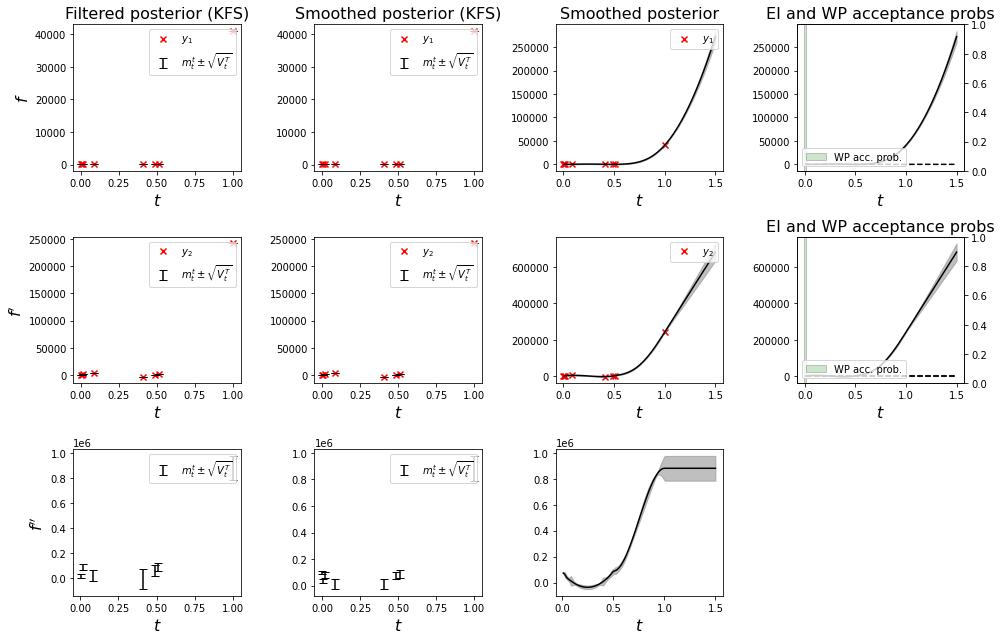

step   0 objective 99.0 alpha 0.004287035439837129
[0.19286137]
[0.         0.08924725 0.19286137]


/Users/stratis/repos/random-walks/random-walks/content/misc/pls/helpers.py:164: RuntimeWarning: invalid value encountered in sqrt
  m[:, i] - v[:, i, i] ** 0.5,
/Users/stratis/repos/random-walks/random-walks/content/misc/pls/helpers.py:165: RuntimeWarning: invalid value encountered in sqrt
  m[:, i] + v[:, i, i] ** 0.5,
/Users/stratis/repos/random-walks/random-walks/content/misc/pls/helpers.py:205: RuntimeWarning: invalid value encountered in sqrt
  m[:, i] - v[:, i, i] ** 0.5,
/Users/stratis/repos/random-walks/random-walks/content/misc/pls/helpers.py:206: RuntimeWarning: invalid value encountered in sqrt
  m[:, i] + v[:, i, i] ** 0.5,


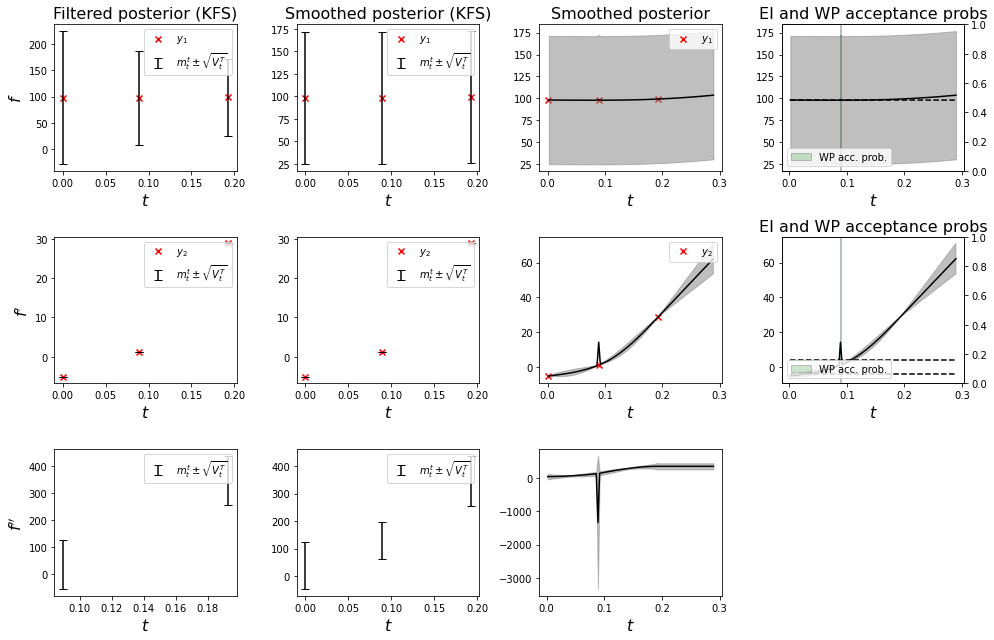

step   1 objective 98.01775512470878 alpha 0.08924725451291221
[0.0047223]


/Users/stratis/repos/random-walks/random-walks/content/misc/pls/helpers.py:164: RuntimeWarning: invalid value encountered in sqrt
  m[:, i] - v[:, i, i] ** 0.5,
/Users/stratis/repos/random-walks/random-walks/content/misc/pls/helpers.py:165: RuntimeWarning: invalid value encountered in sqrt
  m[:, i] + v[:, i, i] ** 0.5,


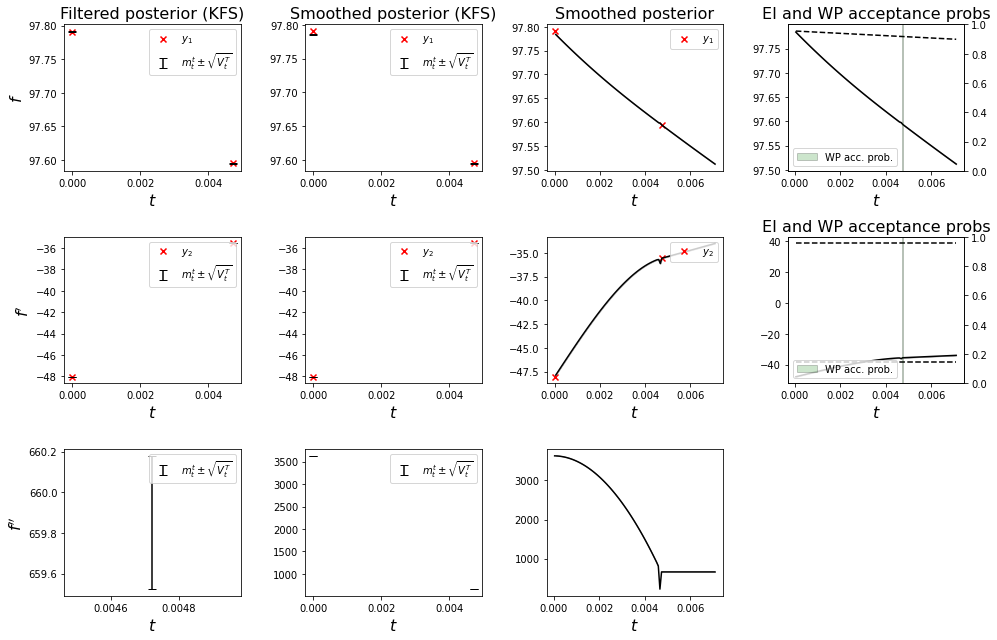

step   2 objective 97.79093269293396 alpha 0.004722303540261711
[0.01496995]
[0.         0.00731841 0.01496995]


/Users/stratis/repos/random-walks/random-walks/content/misc/pls/helpers.py:164: RuntimeWarning: invalid value encountered in sqrt
  m[:, i] - v[:, i, i] ** 0.5,
/Users/stratis/repos/random-walks/random-walks/content/misc/pls/helpers.py:165: RuntimeWarning: invalid value encountered in sqrt
  m[:, i] + v[:, i, i] ** 0.5,
/Users/stratis/repos/random-walks/random-walks/content/misc/pls/helpers.py:205: RuntimeWarning: invalid value encountered in sqrt
  m[:, i] - v[:, i, i] ** 0.5,
/Users/stratis/repos/random-walks/random-walks/content/misc/pls/helpers.py:206: RuntimeWarning: invalid value encountered in sqrt
  m[:, i] + v[:, i, i] ** 0.5,
/Users/stratis/repos/random-walks/random-walks/content/misc/pls/helpers.py:164: RuntimeWarning: invalid value encountered in sqrt
  m[:, i] - v[:, i, i] ** 0.5,
/Users/stratis/repos/random-walks/random-walks/content/misc/pls/helpers.py:165: RuntimeWarning: invalid value encountered in sqrt
  m[:, i] + v[:, i, i] ** 0.5,


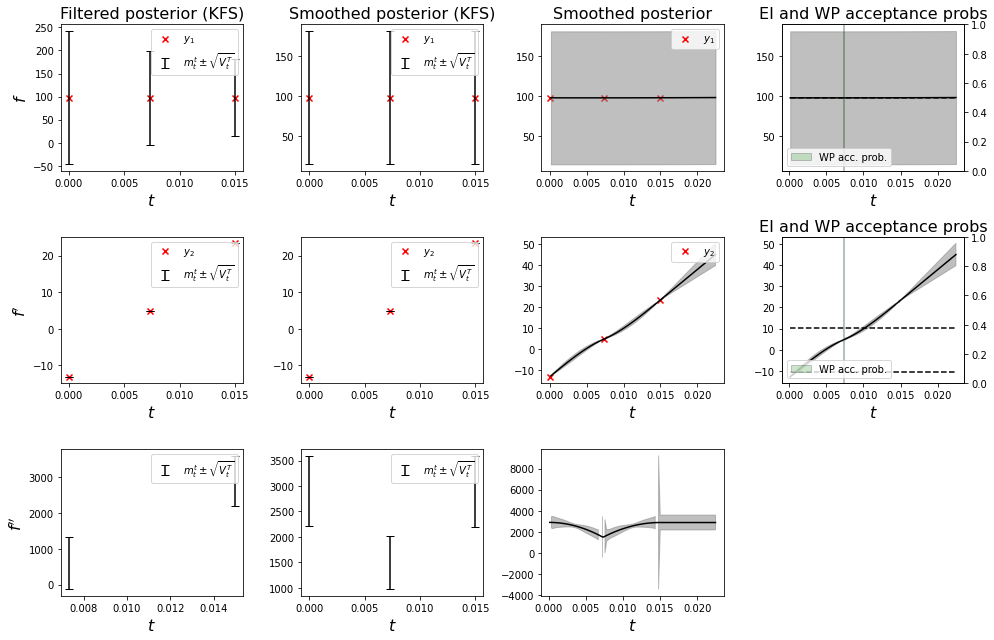

step   3 objective 97.59482590166992 alpha 0.007318408517850487
[0.00516874]
[0.         0.00260557 0.00516874 0.00930374]


/Users/stratis/repos/random-walks/random-walks/content/misc/pls/helpers.py:164: RuntimeWarning: invalid value encountered in sqrt
  m[:, i] - v[:, i, i] ** 0.5,
/Users/stratis/repos/random-walks/random-walks/content/misc/pls/helpers.py:165: RuntimeWarning: invalid value encountered in sqrt
  m[:, i] + v[:, i, i] ** 0.5,
/Users/stratis/repos/random-walks/random-walks/content/misc/pls/helpers.py:205: RuntimeWarning: invalid value encountered in sqrt
  m[:, i] - v[:, i, i] ** 0.5,
/Users/stratis/repos/random-walks/random-walks/content/misc/pls/helpers.py:206: RuntimeWarning: invalid value encountered in sqrt
  m[:, i] + v[:, i, i] ** 0.5,
/Users/stratis/repos/random-walks/random-walks/content/misc/pls/helpers.py:164: RuntimeWarning: invalid value encountered in sqrt
  m[:, i] - v[:, i, i] ** 0.5,
/Users/stratis/repos/random-walks/random-walks/content/misc/pls/helpers.py:165: RuntimeWarning: invalid value encountered in sqrt
  m[:, i] + v[:, i, i] ** 0.5,


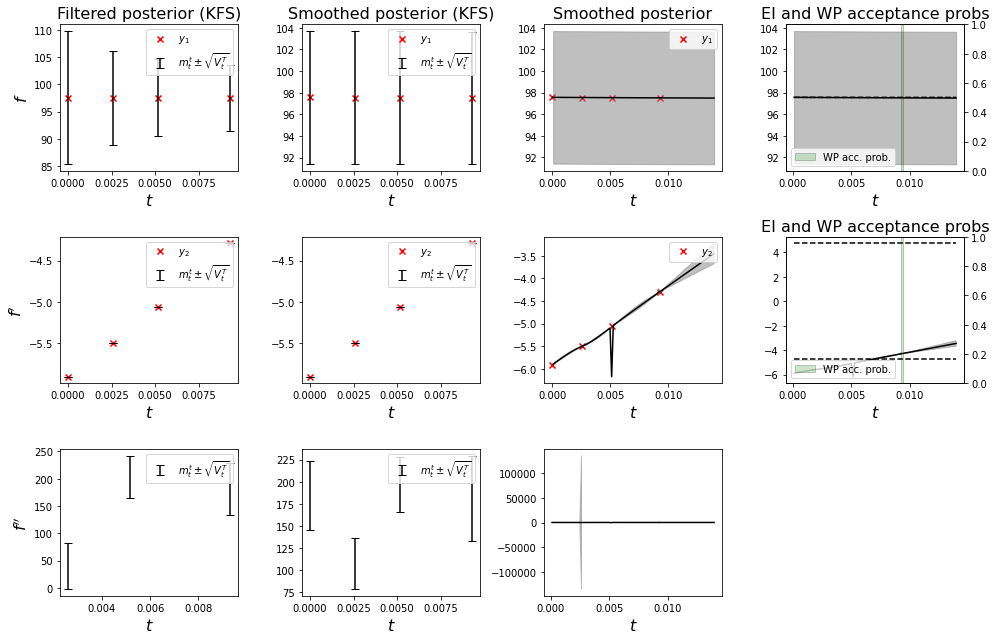

step   4 objective 97.56426143863027 alpha 0.009303735986960585
[0.00627824]


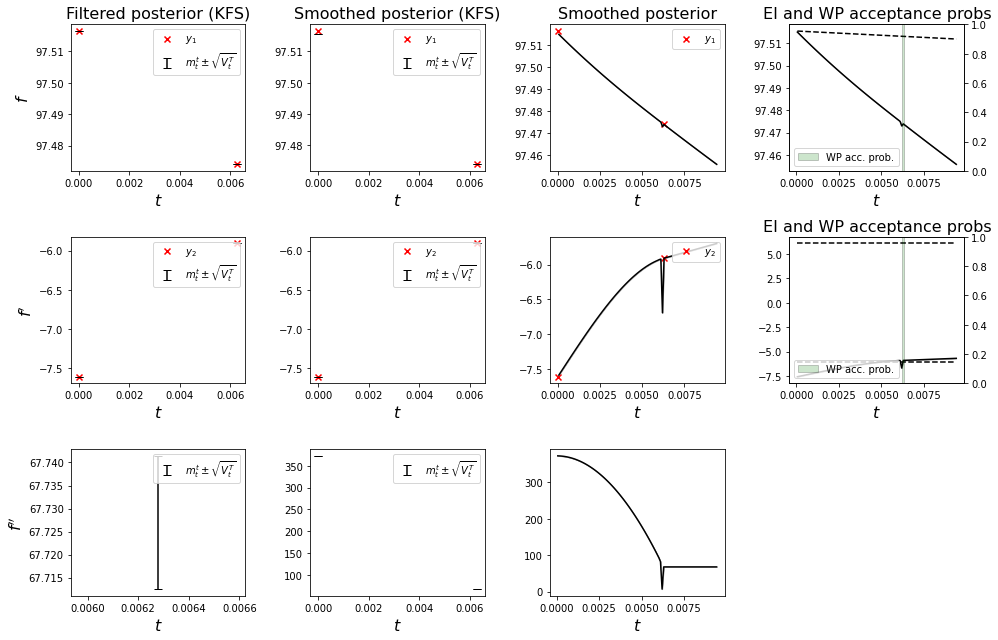

step   5 objective 97.51648130842324 alpha 0.006278241611341548
[0.00767124]
[0.         0.00388175 0.00767124 0.01380824]


[0.         0.00200098 0.00388175 0.0058572  0.00767124 0.01092807
 0.01380824 0.02485482]


[0.         0.00100895 0.00200098 0.00294949 0.00388175 0.00487928
 0.0058572  0.00677335 0.00767124 0.00933378 0.01092807 0.01240138
 0.01380824 0.01986425 0.02485482 0.04473868]


[0.         0.0005157  0.00100895 0.00151694 0.00200098 0.00248897
 0.00294949 0.00343031 0.00388175 0.00439312 0.00487928 0.00538182
 0.0058572  0.00633179 0.00677335 0.00724016 0.00767124 0.00850903
 0.00933378 0.01013781 0.01092807 0.01167227 0.01240138 0.01311306
 0.01380824 0.01690189 0.01986425 0.02241535 0.02485482 0.03620295
 0.04473868 0.08052963]


KeyboardInterrupt: Interrupted by user

In [5]:
c1 = 0.05
c2 = 0.8
wp_thresh = 0.95

ndim = 100
x0 = np.zeros(shape=(ndim,))

standard_rosenbrock = lambda x : rosenbrock(x, a=2)

save_path = datetime.now().strftime('%Y-%m-%d--%H-%M-%S')

xhist = conjugate_gradients(objective=standard_rosenbrock,
                            x0=x0,
                            c1=c1,
                            c2=c2,
                            wp_thresh=wp_thresh, 
                            save_path=save_path)

In [ ]:
np.exp(-20)

In [ ]:
# plt.figure(figsize=(8, 8))

# eps = 2.

# x1, x2 = np.meshgrid(np.linspace(1. - eps, 1 + eps, 40), np.linspace(1. - eps, 1. + eps, 40))
# x = np.stack([x1, x2], axis=-1)
# x = np.reshape(x, (-1, 2))

# f = np.array([standard_rosenbrock(x_)[0] for x_ in x])
# f = np.reshape(f, (x1.shape[0], x1.shape[0]))

# plt.contourf(x1, x2, np.log(f) + 1e-6, cmap='coolwarm', alpha=0.5)
# plt.plot(xhist[:, 0], xhist[:, 1], color='black')
# plt.gca().set_aspect('equal')
# plt.xlim([1. - eps, 1. + eps])
# plt.ylim([1. - eps, 1. + eps])
# plt.show()

In [ ]:
# import scipy as scp

# ndim = 10
# x0 = np.zeros(shape=(ndim,))

# standard_rosenbrock_f = lambda x : rosenbrock(x, a=10)[0]
# standard_rosenbrock_df = lambda x : rosenbrock(x, a=10)[1]

# scp.optimize.minimize(fun=standard_rosenbrock_f,
#                       x0=x0,
#                       method='CG',
#                       jac=standard_rosenbrock_df,
#                       options={'maxiter' : 1000})

# Plotting searches



In [ ]:
i = 3

names = ['t', 'y', 'wp_probs', 'mf', 'Vf', 'ms', 'Vs', 'iVC', 'post_probs']
loaded = [np.load(f'{os.getcwd()}/{save_path}/{str(i).zfill(5)}/{name}.npy') for name in names]
t, y, wp_probs, mf, Vf, ms, Vs, iVC, post_probs = loaded

j = 0

plot_linesearch(c1=c1,
                c2=c2,
                t_data=t,
                mf=mf[j:j+1],
                Vf=Vf[j:j+1],
                ms=ms[j:j+1],
                Vs=Vs[j:j+1],
                iVC=iVC[j:j+1],
                post_probs=np.ones_like(post_probs[j:j+1]),
                wp_probs=wp_probs,
                x=None,
                y=y)

In [ ]:
log_nsr = -20.
scale = ((3 / 80) ** 0.5 * (np.max(t) - np.min(t))) ** -1. # 1 

y_ = y[:].copy()
y_[:, 1] = y_[:, 1] / scale
mf, Vf, ms, Vs, iVC, theta2, nlml = kalman_filter_smoother(scale * t, y_, log_nsr=log_nsr, verbose=True)

print(theta2, nlml)

plot_linesearch(c1=c1,
                c2=c2,
                t_data=t * scale,
                mf=mf[None, :],
                Vf=Vf[None, :],
                ms=ms[None, :],
                Vs=Vs[None, :],
                iVC=iVC[None, :],
                post_probs=np.array([1.]),
                wp_probs=wp_probs,
                x=None,
                y=y_,
                options={'kfs_info'  : f'log-NSR: {log_nsr:.2f}, scale: {scale:.0f}',
                         'save_path' : f'figures/{log_nsr:.2f}_{scale:.0f}.pdf'})


# diff [0.00152318 1.07406326]
# quad [107.11845063]
# diff [-7.05007756e-05  5.39869149e-01]
# quad [1.65557898e+08]
# diff [0.00216854 1.52950542]
# quad [2.49449633e+08]

In [ ]:
Vf[0]

In [ ]:
Vs[0]

In [ ]:
y_, scale * (t[1] - t[0]) * y_[0, 1]

In [ ]:
np.exp(-20)

# Notes

- Check numerical stability. Sometimes error bars seem way too large.
- Why does $f''$ seem constant?

In [ ]:
np.linalg.eig(np.array([[ 1.41608189e-13, -5.35776101e-13],
 [-5.35776101e-13,  1.71858928e-09]]))